In [1]:
from typing import Callable
from os import makedirs
from os.path import join
import numpy as np
import pandas as pd
import warnings
from verma_net_radiation import process_verma_net_radiation_table
from STIC_JPL import process_STIC_table
from monte_carlo_sensitivity import perturbed_run, sensitivity_analysis, divide_by_unperturbed, divide_absolute_by_unperturbed
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [2]:
import logging

logging.getLogger().handlers = []

In [3]:
normalization_function = divide_absolute_by_unperturbed

In [4]:
input_df = pd.read_csv("inputs.csv")
input_df = input_df[input_df.fAPARmax != 0]
input_df

,tower,lat,lon,orbit,scene,tile,date_UTC,doy,time_solar,AOT,...,Topt,fAPARmax,LE_insitu,H_insitu,Rn_insitu,G_insitu,SWin_insitu,SWout_insitu,LWin_insitu,LWout_insitu
0,US-Ha2,42.5393,-72.1779,9254,9,18TYN,2020-02-22,53,2020-02-21 19:11:17.304,0.088195,...,0.0,0.5545,23.770000,NaN,NaN,NaN,-1.680,0.758,266.0,307.0
1,US-Ha2,42.5393,-72.1779,10150,9,18TYN,2020-04-20,111,2020-04-19 19:11:17.304,0.237342,...,0.0,0.5545,37.980000,100.200000,128.80,NaN,-4.610,2.300,257.0,354.0
2,US-Ha2,42.5393,-72.1779,10352,9,18TYN,2020-05-03,124,2020-05-02 19:11:17.304,0.107484,...,0.0,0.5545,68.060000,152.300000,261.30,NaN,-4.050,0.952,316.0,419.0
3,US-Ha2,42.5393,-72.1779,10684,7,18TYN,2020-05-24,145,2020-05-23 19:11:17.304,0.094339,...,0.0,0.5545,NaN,NaN,NaN,NaN,-0.525,0.463,381.0,425.0
4,US-Ha2,42.5393,-72.1779,11069,8,18TYN,2020-06-18,170,2020-06-17 19:11:17.304,0.050474,...,0.0,0.5545,122.200000,292.500000,657.60,NaN,10.000,2.320,310.0,408.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,US-xUK,39.0404,-95.1921,10994,7,15SUD,2020-06-13,165,2020-06-12 17:39:13.896,0.107889,...,5.8,0.4664,NaN,NaN,368.81,17.024,347.290,67.140,411.0,488.9
132,US-xUK,39.0404,-95.1921,11909,6,15SUD,2020-08-11,224,2020-08-10 17:39:13.896,0.143261,...,5.8,0.4664,131.783751,6.519267,279.97,14.633,347.330,59.370,363.0,440.6
133,US-xUK,39.0404,-95.1921,16668,8,15SUD,2021-06-14,165,2021-06-13 17:39:13.896,0.121046,...,5.8,0.4664,NaN,NaN,NaN,NaN,347.290,67.140,411.0,488.9
134,US-xUK,39.0404,-95.1921,16810,8,15SUD,2021-06-23,174,2021-06-22 17:39:13.896,0.109902,...,5.8,0.4664,237.726708,187.862743,764.71,16.236,385.650,67.010,387.0,466.6


In [5]:
def process_verma_STIC_table(input_df: pd.DataFrame) -> pd.DataFrame:
    df = input_df.copy()
    df["Rn"] = df["Rn_insitu"]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        result = process_STIC_table(
            process_verma_net_radiation_table(input_df),
            # df,
            max_iterations=30,
            use_variable_alpha=False
        )

    return result

In [6]:
processed = process_verma_STIC_table(input_df)
processed

,tower,lat,lon,orbit,scene,tile,date_UTC,doy,time_solar,AOT,...,SWout_insitu,LWin_insitu,LWout_insitu,LE_max_change,iteration,LE,LE_change,LEt,PT,G
0,US-Ha2,42.5393,-72.1779,9254,9,18TYN,2020-02-22,53,2020-02-21 19:11:17.304,0.088195,...,0.758,266.0,307.0,0.026694,2,0.000000,0.0,0.000000,0.000000,0.000000
1,US-Ha2,42.5393,-72.1779,10150,9,18TYN,2020-04-20,111,2020-04-19 19:11:17.304,0.237342,...,2.300,257.0,354.0,0.026694,2,0.000000,0.0,0.000000,0.299311,0.000000
2,US-Ha2,42.5393,-72.1779,10352,9,18TYN,2020-05-03,124,2020-05-02 19:11:17.304,0.107484,...,0.952,316.0,419.0,0.026694,2,0.000000,0.0,0.000000,0.144238,0.000000
3,US-Ha2,42.5393,-72.1779,10684,7,18TYN,2020-05-24,145,2020-05-23 19:11:17.304,0.094339,...,0.463,381.0,425.0,0.026694,2,NaN,NaN,NaN,NaN,NaN
4,US-Ha2,42.5393,-72.1779,11069,8,18TYN,2020-06-18,170,2020-06-17 19:11:17.304,0.050474,...,2.320,310.0,408.0,0.026694,2,12.788436,0.0,6.582825,16.847240,0.805118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,US-xUK,39.0404,-95.1921,10994,7,15SUD,2020-06-13,165,2020-06-12 17:39:13.896,0.107889,...,67.140,411.0,488.9,0.026694,2,46.151924,0.0,25.240947,60.724614,2.944869
132,US-xUK,39.0404,-95.1921,11909,6,15SUD,2020-08-11,224,2020-08-10 17:39:13.896,0.143261,...,59.370,363.0,440.6,0.026694,2,25.069452,0.0,9.510428,36.658227,2.437244
133,US-xUK,39.0404,-95.1921,16668,8,15SUD,2021-06-14,165,2021-06-13 17:39:13.896,0.121046,...,67.140,411.0,488.9,0.026694,2,NaN,NaN,NaN,NaN,NaN
134,US-xUK,39.0404,-95.1921,16810,8,15SUD,2021-06-23,174,2021-06-22 17:39:13.896,0.109902,...,67.010,387.0,466.6,0.026694,2,NaN,NaN,NaN,NaN,NaN


In [7]:
processed.columns

Index(['tower', 'lat', 'lon', 'orbit', 'scene', 'tile', 'date_UTC', 'doy',
       'time_solar', 'AOT', 'COT', 'vapor_gccm', 'ozone_cm', 'SZA', 'KG',
       'BESSinst', 'ESI', 'ESIdaily', 'ESIdailyUncertainty', 'ETdaily',
       'ETdailyUncertainty', 'ETinstUncertainty', 'EmisWB', 'GPP', 'LST',
       'LST_err', 'MOD16inst', 'NDVI-UQ', 'PET', 'PTJPLSMcanopy',
       'PTJPLSMinst', 'PTJPLSMinterception', 'PTJPLSMsoil', 'RH', 'Rg', 'Rn',
       'SM', 'STICcanopy', 'STICinst', 'Ta', 'WUE', 'albedo-UQ', 'height',
       'radiance_1', 'radiance_2', 'radiance_3', 'radiance_4', 'radiance_5',
       'view_zenith', 'year', 'Ta_C', 'ST_K', 'NDVI', 'albedo', 'ST_C',
       'elevation_km', 'Ra', 'UV', 'VIS', 'NIR', 'VISdiff', 'NIRdiff',
       'VISdir', 'NIRdir', 'SWout', 'LWin', 'LWout', 'hour_of_day', 'Topt',
       'fAPARmax', 'LE_insitu', 'H_insitu', 'Rn_insitu', 'G_insitu',
       'SWin_insitu', 'SWout_insitu', 'LWin_insitu', 'LWout_insitu',
       'LE_max_change', 'iteration', 'LE', 'LE_chang

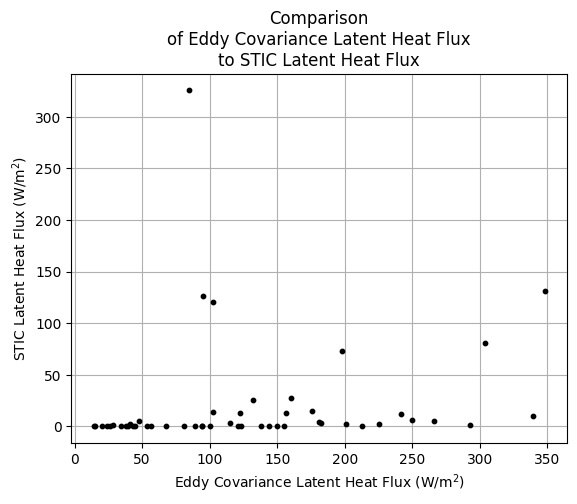

In [8]:
# plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
plt.scatter(x=processed.LE_insitu, y=processed.LE, color='black', s=10, zorder=5)  # Adjust the 's' parameter to make dots thinner
plt.grid(True, zorder=0)
plt.xlabel("Eddy Covariance Latent Heat Flux (W/m$^2$)")
plt.ylabel("STIC Latent Heat Flux (W/m$^2$)")
plt.title("Comparison\nof Eddy Covariance Latent Heat Flux\nto STIC Latent Heat Flux")

plt.show()

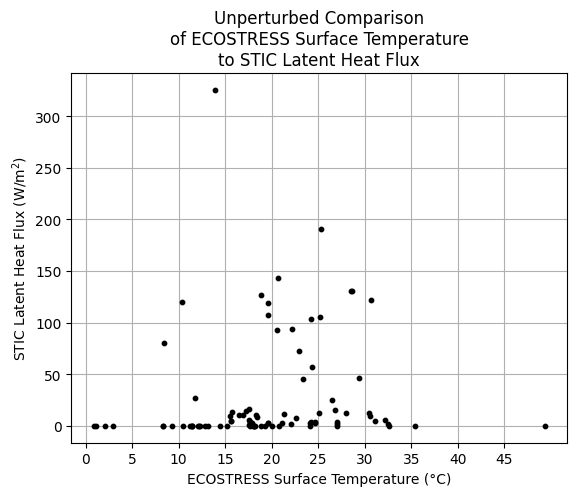

In [9]:
plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
plt.scatter(x=processed.ST_C, y=processed.LE, color='black', s=10, zorder=5)  # Adjust the 's' parameter to make dots thinner
plt.grid(True, zorder=0)
plt.xlabel("ECOSTRESS Surface Temperature (°C)")
plt.ylabel("STIC Latent Heat Flux (W/m$^2$)")
plt.title("Unperturbed Comparison\nof ECOSTRESS Surface Temperature\nto STIC Latent Heat Flux")

plt.savefig("Unperturbed Comparison of ECOSTRESS Surface Temperature to STIC Latent Heat Flux.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Unperturbed Comparison of ECOSTRESS Surface Temperature to STIC Latent Heat Flux.svg", format='svg', bbox_inches='tight')

plt.show()

In [10]:
input_variable = "ST_C"
output_variable = "LE"

results = perturbed_run(
    input_df=input_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=process_verma_STIC_table,
    normalization_function=normalization_function
)

# plt.scatter(x=processed.ST_C, y=processed.LE, color='black')

results

,input_variable,output_variable,input_unperturbed,input_perturbation,input_perturbation_std,input_perturbed,output_unperturbed,output_perturbation,output_perturbation_std,output_perturbed
400,ST_C,LE,28.03,-11.644310,0.415423,16.38569,12.788436,-2.096365,0.163927,10.692071
401,ST_C,LE,28.03,-3.658328,0.130515,24.371672,12.788436,2.000421,0.156424,14.788857
402,ST_C,LE,28.03,0.201695,0.007196,28.231695,12.788436,-0.096187,0.007521,12.692249
403,ST_C,LE,28.03,16.467819,0.587507,44.497819,12.788436,-5.437827,0.425214,7.350609
404,ST_C,LE,28.03,-2.846740,0.101560,25.18326,12.788436,1.572435,0.122958,14.360870
...,...,...,...,...,...,...,...,...,...,...
13295,ST_C,LE,26.43,-6.109039,0.231140,20.320961,25.069452,-2.310858,0.092178,22.758593
13296,ST_C,LE,26.43,5.686997,0.215172,32.116997,25.069452,-5.728339,0.228499,19.341113
13297,ST_C,LE,26.43,-0.071592,0.002709,26.358408,25.069452,0.006602,0.000263,25.076054
13298,ST_C,LE,26.43,11.488627,0.434681,37.918627,25.069452,-10.829001,0.43196,14.240451


In [11]:
# np.nanstd(filtered_results.output_perturbation_std)

In [12]:
# plt.scatter(filtered_results.input_perturbation, filtered_results.output_perturbation)

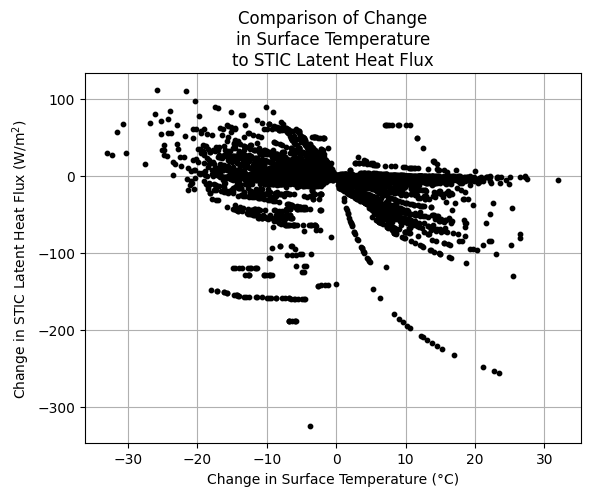

In [13]:
# plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
# plt.ylim(-350, 150)
plt.scatter(x=results.input_perturbation, y=results.output_perturbation, color='black', s=10, zorder=5)  # Adjust the 's' parameter to make dots thinner
plt.grid(True, zorder=0)
plt.xlabel("Change in Surface Temperature (°C)")
plt.ylabel("Change in STIC Latent Heat Flux (W/m$^2$)")
plt.title("Comparison of Change\nin Surface Temperature\nto STIC Latent Heat Flux")

plt.savefig("Comparison of Change in Surface Temperature to STIC Latent Heat Flux.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Comparison of Change in Surface Temperature to STIC Latent Heat Flux.svg", format='svg', bbox_inches='tight')

plt.show()

In [14]:
# input_variables = ["LST", "NDVI", "albedo", "Ta_C", "RH", "Rg"]
input_variables = ["ST_C", "NDVI", "albedo", "Ta_C", "RH"]
output_variables = ["LE"]

perturbation_df, sensitivity_metrics_df = sensitivity_analysis(
    input_df=input_df,
    input_variables=input_variables,
    output_variables=output_variables,
    forward_process=process_verma_STIC_table,
    normalization_function=normalization_function
)

sensitivity_metrics_df

/opt/homebrew/Caskroom/miniforge/base/envs/STIC-JPL/lib/python3.10/site-packages/monte_carlo_sensitivity/sensitivity_analysis.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perturbation_df = pd.concat([perturbation_df, run_results])
/opt/homebrew/Caskroom/miniforge/base/envs/STIC-JPL/lib/python3.10/site-packages/monte_carlo_sensitivity/sensitivity_analysis.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sensitivity_metrics_df = pd.concat([sensitivity_metrics_df, pd.DataFrame([[


,input_variable,output_variable,metric,value
0,ST_C,LE,correlation,0.220908
0,ST_C,LE,r2,0.048800
0,ST_C,LE,mean_normalized_change,0.705988
0,NDVI,LE,correlation,0.520474
0,NDVI,LE,r2,0.270893
0,NDVI,LE,mean_normalized_change,0.023346
0,albedo,LE,correlation,0.533705
0,albedo,LE,r2,0.284841
0,albedo,LE,mean_normalized_change,0.049697
0,Ta_C,LE,correlation,0.229937


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_87928/668851651.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])


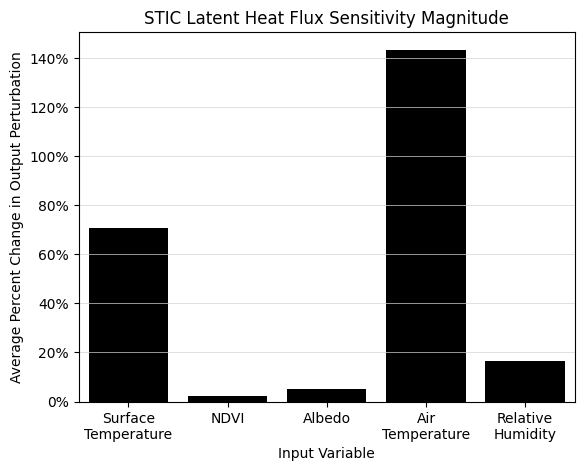

In [15]:
df = sensitivity_metrics_df
df = df[(df.output_variable == "LE") & (df.metric == "mean_normalized_change")]
ax = sns.barplot(x=df.input_variable, y=df.value * 100, color='black')
ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])
# ax.set_ylim(0, 160)  # Set y-axis range from 0 to 160
plt.xlabel("Input Variable")
plt.ylabel("Average Percent Change in Output Perturbation")
plt.title("STIC Latent Heat Flux Sensitivity Magnitude")
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5)  # Add light gray horizontal gridlines only

# Add percent sign to y-axis tick labels
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))

plt.savefig("STIC Latent Heat Flux Sensitivity Magnitude.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("STIC Latent Heat Flux Sensitivity Magnitude.svg", format='svg', bbox_inches='tight')

plt.show()

/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_87928/837320148.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])


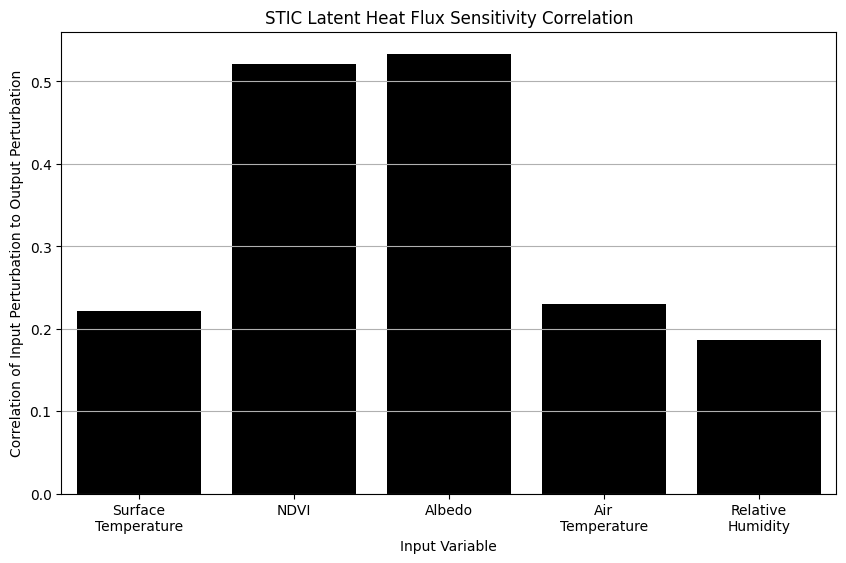

In [16]:
# Create the plot
df = sensitivity_metrics_df
df = df[(df.output_variable == "LE") & (df.metric == "correlation")]
plt.figure(figsize=(10, 6))  # Adjust the figure size
ax = sns.barplot(x=df.input_variable, y=df.value, color='black')
ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])
# plt.ylim(0, 0.8)
plt.xlabel("Input Variable")
plt.ylabel("Correlation of Input Perturbation to Output Perturbation")
plt.title("STIC Latent Heat Flux Sensitivity Correlation")
plt.grid(axis='y')  # Add horizontal gridlines

# Save the plot as JPEG and SVG with tight bounding box
plt.savefig("STIC Latent Heat Flux Sensitivity Correlation.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("STIC Latent Heat Flux Sensitivity Correlation.svg", format='svg', bbox_inches='tight')

plt.show()